In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def plot_series(time, series, format = '-', start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)

def trend(time, slope = 0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1/np.exp(season_time * 3))

def seasonality(time, period, amplitude = 1, phase = 0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [9]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

series += noise(time, noise_level, seed = 42)

In [10]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [16]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape = [window_size])
model = tf.keras.Sequential([l0])

model.compile(optimizer = tf.keras.optimizers.SGD(lr = 1e-6, momentum = 0.9), loss = 'mse', metrics = ['accuracy'])
model.fit(dataset, epochs = 100, verbose = 1)


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Epoch 1/100
31/31 [==============================] - 1s 20ms/step - loss: 1727.2153 - accuracy: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 0s 823us/step - loss: 262.4458 - accuracy: 0.0000e+00
Epoch 3/100
31/31 [==============================] - 0s 831us/step - loss: 166.9753 - accuracy: 0.0000e+00
Epoch 4/100
31/31 [==============================] - 0s 868us/step - loss: 138.4273 - accuracy: 0.0000e+00
Epoch 5/100
31/31 [==============================] - 0s 894us/step - loss: 123.9024 - accuracy: 0.0000e+00
Epoch 6/100
31/31 [==============================] - 0s 806us/step - loss: 112.8746 - accuracy: 0.0000e+00
Epoch 7/100
31/31 [==============================] - 0s 851us/step - loss: 106.7283 - accuracy: 0.0000e+00
Epoch 8/100
31/31 [==============================] - 0s 809us/step - loss: 99.8553 - accuracy: 0.0000e+00
Epoch 9/100
31/31 [==============================] - 0s 880us/

31/31 [==============================] - 0s 833us/step - loss: 45.0069 - accuracy: 0.0000e+00
Epoch 77/100
31/31 [==============================] - 0s 796us/step - loss: 46.2849 - accuracy: 0.0000e+00
Epoch 78/100
31/31 [==============================] - 0s 816us/step - loss: 45.1628 - accuracy: 0.0000e+00
Epoch 79/100
31/31 [==============================] - 0s 905us/step - loss: 45.4288 - accuracy: 0.0000e+00
Epoch 80/100
31/31 [==============================] - 0s 838us/step - loss: 45.1220 - accuracy: 0.0000e+00
Epoch 81/100
31/31 [==============================] - 0s 888us/step - loss: 44.5476 - accuracy: 0.0000e+00
Epoch 82/100
31/31 [==============================] - 0s 761us/step - loss: 44.8158 - accuracy: 0.0000e+00
Epoch 83/100
31/31 [==============================] - 0s 772us/step - loss: 45.4583 - accuracy: 0.0000e+00
Epoch 84/100
31/31 [==============================] - 0s 886us/step - loss: 44.3263 - accuracy: 0.0000e+00
Epoch 85/100
31/31 [==============================

In [17]:
print("Layer weights = {}".format(l0.get_weights()))

Layer weights = [array([[-0.03024518],
       [-0.00444156],
       [-0.00078844],
       [ 0.02258332],
       [ 0.03722422],
       [-0.04061478],
       [-0.02112405],
       [ 0.03599463],
       [-0.01561766],
       [ 0.08012119],
       [-0.02858727],
       [-0.05317844],
       [-0.06489955],
       [ 0.04072175],
       [ 0.05272447],
       [ 0.06215809],
       [ 0.0486878 ],
       [ 0.15759704],
       [ 0.34169367],
       [ 0.3670909 ]], dtype=float32), array([0.0199619], dtype=float32)]


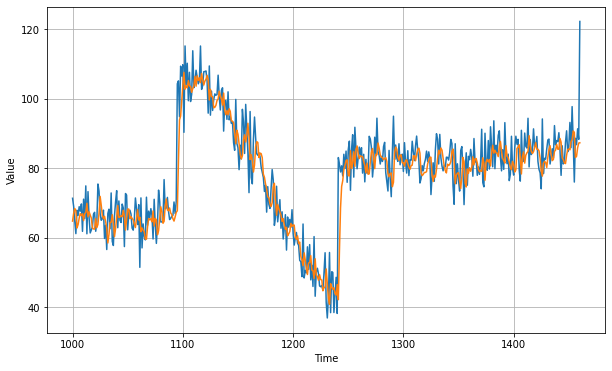

In [18]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.9281497